### Pytorch Helmet detection using Faster RCNN Transfer learning

Segregating dataset into train & validation (total 5000 images: train:4500, val:500)

In [54]:
from google.cloud import storage
client = storage.Client()
BUCKET_NAME = 'my-project-0004-bucket02'
blob_name = "helmet"
bucket = client.get_bucket(BUCKET_NAME)
elements = bucket.list_blobs()
files=[a.name for a in elements]

In [72]:
!ls

annotations  images  lyw_cam1_with_pii_H265.mp4  savedmodel  train  val


In [3]:
import os
os.chdir('./helmet')

In [4]:
# !mkdir helmet

In [5]:
!gsutil ls -lR 'gs://my-project-0004-bucket02/helmet/images/*' 


    215330  2023-01-14T14:12:56Z  gs://my-project-0004-bucket02/helmet/images/hard_hat_workers0.png
    303581  2023-01-14T14:12:57Z  gs://my-project-0004-bucket02/helmet/images/hard_hat_workers1.png
    156273  2023-01-14T04:32:28Z  gs://my-project-0004-bucket02/helmet/images/hard_hat_workers10.png
    249516  2023-01-14T14:14:03Z  gs://my-project-0004-bucket02/helmet/images/hard_hat_workers100.png
    257579  2023-01-14T14:22:19Z  gs://my-project-0004-bucket02/helmet/images/hard_hat_workers1000.png
    291181  2023-01-14T14:22:19Z  gs://my-project-0004-bucket02/helmet/images/hard_hat_workers1001.png
    221136  2023-01-14T14:22:21Z  gs://my-project-0004-bucket02/helmet/images/hard_hat_workers1002.png
    203837  2023-01-14T14:22:21Z  gs://my-project-0004-bucket02/helmet/images/hard_hat_workers1003.png
    283588  2023-01-14T14:22:21Z  gs://my-project-0004-bucket02/helmet/images/hard_hat_workers1004.png
    289215  2023-01-14T14:22:23Z  gs://my-project-0004-bucket02/helmet/images/hard

In [6]:
!gsutil ls -lR 'gs://my-project-0004-bucket02/helmet/annotations/*' 


# my-project-0004-bucket02/helmet/annotations

      4584  2023-01-14T07:09:11Z  gs://my-project-0004-bucket02/helmet/annotations/hard_hat_workers0.xml
      3253  2023-01-14T07:10:54Z  gs://my-project-0004-bucket02/helmet/annotations/hard_hat_workers1.xml
      1243  2023-01-14T07:14:59Z  gs://my-project-0004-bucket02/helmet/annotations/hard_hat_workers10.xml
      1903  2023-01-14T13:24:40Z  gs://my-project-0004-bucket02/helmet/annotations/hard_hat_workers100.xml
       906  2023-01-14T06:31:52Z  gs://my-project-0004-bucket02/helmet/annotations/hard_hat_workers1000.xml
      1573  2023-01-14T06:29:11Z  gs://my-project-0004-bucket02/helmet/annotations/hard_hat_workers1001.xml
      1574  2023-01-14T06:32:29Z  gs://my-project-0004-bucket02/helmet/annotations/hard_hat_workers1002.xml
      2253  2023-01-14T06:33:35Z  gs://my-project-0004-bucket02/helmet/annotations/hard_hat_workers1003.xml
      1912  2023-01-14T06:37:11Z  gs://my-project-0004-bucket02/helmet/annotations/hard_hat_workers1004.xml
      2576  2023-01-14T06:39:03Z  gs:

In [7]:
# !gsutil cp -R 'gs://my-project-0004-bucket02/helmet/*' './helmet/'

# !gsutil find 'gs://my-project-0004-bucket02/helmet/annotations/'  ! -name . -prune -print | grep -c / 


In [8]:
# storing file paths
file_path = './' #'../input/hard-hat-detection/'
ann_path = file_path + 'annotations/'
img_path = file_path + 'images/'

In [9]:
# segregate the dataset into train & validation (there are 5000 images)(train:4500, val:500)

from pathlib import Path

path_annotations = []
for i in Path(ann_path).glob('*.xml'):
    path_annotations.append(i)
path_annotations = sorted(path_annotations) #contains path to 5000 annots

path_images = []
for i in Path(img_path).glob('*.png'):
    path_images.append(i)
path_images = sorted(path_images) #contains path to 5000 images

In [10]:
# Split data : 90% Train, 10% Val
path_train_annot = path_annotations[:4500]
path_train_images = path_images[:4500]

path_val_annot = path_annotations[4500:5000]
path_val_images = path_images[4500:5000]

In [11]:
# making dirs to segregate train & val images & annotations & also to save best trained model
import os

# Creating directories to put train & val data
os.makedirs('./train/annotations',exist_ok = True)
os.makedirs('./train/images', exist_ok = True)
os.makedirs('./val/annotations', exist_ok = True)
os.makedirs('./val/images', exist_ok = True)
os.makedirs('./savedmodel', exist_ok = True)

In [12]:
# copying images & xml annotations from input to working folder
import shutil
from tqdm import tqdm

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_train_annot, path_train_images))):
    shutil.copy(path_img, './train/images/' + path_img.parts[-1])
    shutil.copy(path_annot, './train/annotations/' + path_annot.parts[-1])
    
for i, (path_annot, path_img) in tqdm(enumerate(zip(path_val_annot, path_val_images))):
    shutil.copy(path_img, './val/images/' + path_img.parts[-1])
    shutil.copy(path_annot, './val/annotations/' + path_annot.parts[-1])
# cpu 2min

4500it [00:23, 189.62it/s]
497it [00:02, 187.49it/s]


Initialization & Image Transformations

In [13]:
import torch

BATCH_SIZE = 8 #increase / decrease according to memeory
NUM_EPOCHS = 10 # number of epochs to train for
NUM_WORKERS = 2
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = './train'
# validation images and XML files directory
VALID_DIR = './val'

# classes: 0 index is reserved for background
CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
NUM_CLASSES = len(CLASS_NAME)

In [14]:
# %pip install -U albumentations
%pip install opencv-python==4.5.5.64


Note: you may need to restart the kernel to use updated packages.


In [15]:
# Apply transform to image
import albumentations as A #new method, customizable transformations
from albumentations.pytorch import ToTensorV2

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc','label_fields': ['labels']}
    )

# define the validation transforms (validation data shud not be augmented)
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

# The collate_fn() will help us take care of tensors of varying sizes while creating
# the training and validation data loaders.
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

Prepare Pytorch Dataset

In [16]:
# Prepare the pytorch dataset

from torch.utils.data import Dataset, DataLoader
import glob, matplotlib.pyplot as plt, matplotlib.patches as patches
import xml.etree.ElementTree as ET


# foll is the class to create pytorch dataset from images(.png) & annotations(.xml)
class SafetyHelmDataset(Dataset):
    def __init__(self, dir_path, class_name, transforms=None):
        self.dir_path = dir_path
        self.class_name = class_name
        self.transforms = transforms
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/images/*.png")
        self.all_images = sorted(self.image_paths)
        
        
    def __getitem__(self, idx: int):
        image_name = self.all_images[idx] #reading image one by one
        
        image = plt.imread(image_name) #read the image
        image /= 255.0 #normalize pixels b/w 0 & 1
        
        # capture the corresponding xml file for getting annotations
        annot_filepath = os.path.join(f'{self.dir_path}/annotations/', Path(image_name).parts[-1][:-4] + '.xml')
        
        boxes, labels = [], []
        root = ET.parse(annot_filepath).getroot() #reading xml file
        
        # extracting box coordinates from xml annotations
        for member in root.findall('object'):
            # map the current object name to classes to get the label index
            labels.append(self.class_name.index(member.find('name').text))
            
            # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            boxes.append([xmin, ymin, xmax, ymax])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # prepare the final target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        image_id = torch.tensor([idx])
        target['image_id'] = image_id
        
        # apply image transforms
        if self.transforms:
            sample = self.transforms(image=image, bboxes=target['boxes'], labels=labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image, target #these are the o/p of this class
        
        
    def __len__(self):
        return len(self.all_images)


In [17]:
# creating object of the class SafetyHelmetDataset which takes images & annotations folder,
# class_name & transformations as arguments & o/p image & bounding box coordinates &
# corresponding class_names

train_dataset = SafetyHelmDataset(TRAIN_DIR, CLASS_NAME, get_train_transform())
valid_dataset = SafetyHelmDataset(VALID_DIR, CLASS_NAME, get_valid_transform())

train_loader = DataLoader( #for loading data in batches, pytorch requires image as channel 1st e.g (3(channel),640(ht),480(wd))
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

len(train_dataset), len(valid_dataset)

(4500, 497)

Visualizing transformed samples from train dataset

In [18]:
import matplotlib.pyplot as plt 

In [19]:
# functions to display samples a/w bounding box
import numpy as np, scipy

def img_show(img, ax = None, figsize=(16,8)): #function to show image
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.tick_top()
    ax.imshow(img)
    return ax
        
def draw_box(img, ax, bb, lbl): #func to draw bounding box
    if lbl=='helmet':
        color_lbl='red'
    elif lbl=='head':
        color_lbl='yellow'
    else:
        color_lbl='blue'
    
    # rectangle draws bbox around the class
    rect = patches.Rectangle(
        (int(bb[0]),int(bb[1])), int(bb[2])-int(bb[0]), int(bb[3])-int(bb[1]),
        fill=False, edgecolor=color_lbl, lw=2
    )
    ax.add_patch(rect)


def plot_sample(a_img, tgt, ax=None, figsize=(16,8)):
    img = np.array(a_img).copy() #making deep copy for reproducibility (else if run 2nd time it gives err)
    img = img*255 #multiplying with 255 becoz in augmtn pixels r normalized
    img = np.transpose(img, (2,1,0)) #making channel 1st to channel last (i.e from (3,416,416) to (416,416,3))
    tr_img = scipy.ndimage.rotate(img, 270, reshape=False) #rotatg becoz rcvd img was hztlly left faced
    tr_img = np.flip(tr_img, axis=1) #mirroring the image becoz rcvd img was flipped
    ax = img_show(tr_img, ax=ax)
    
    for box_id in range(len(tgt['boxes'])):
        box = tgt['boxes'][box_id] #target['boxes'][box_id] contains (xmin, ymin, xmax, ymax) i.e bbox coor for each label
        lbl = CLASS_NAME[tgt['labels'][box_id]] #converting index back to str labels i.e 1 to 'helmet'
        draw_box(tr_img, ax, box, lbl) #drawing multiple bbox on single image using matplotlib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


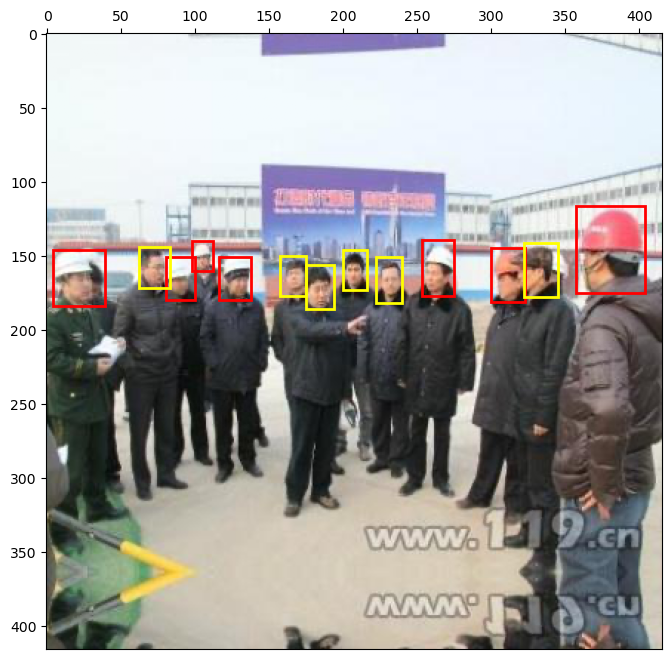

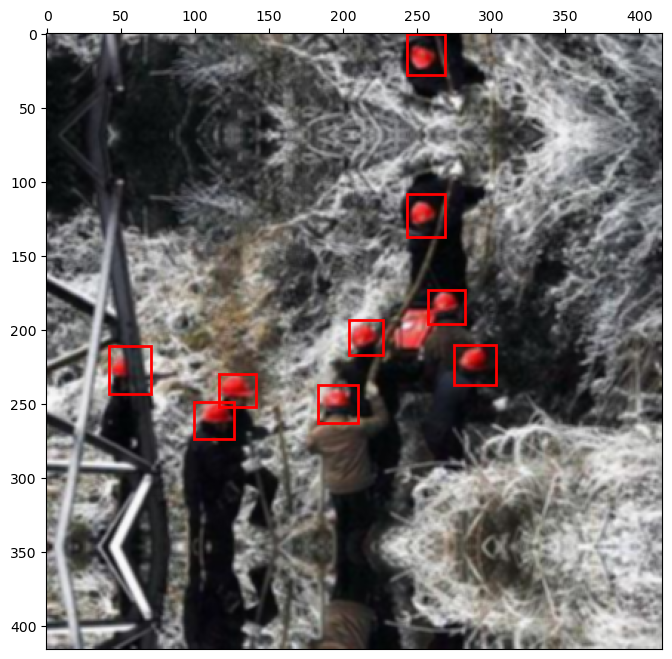

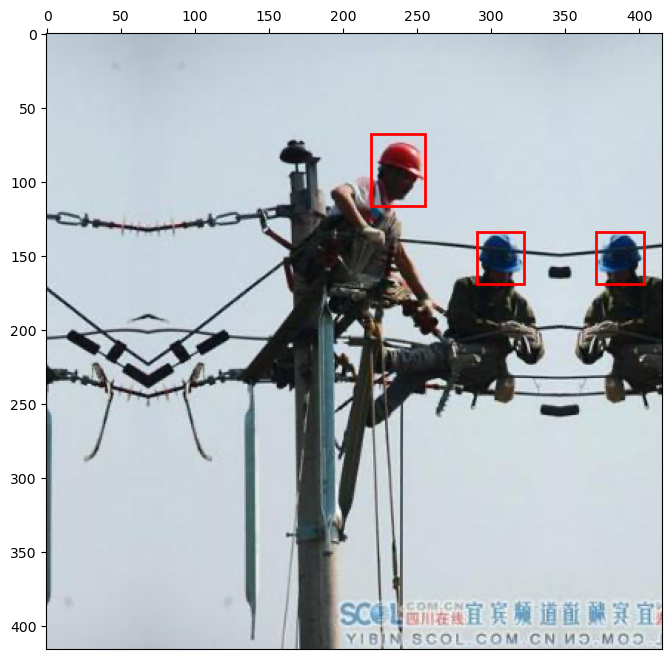

In [20]:
# red=helmet, yellow=head
for i in range(3):
    a_img, trgt = train_dataset[i] #extracting image info from albumentated train dataset
    plot_sample(a_img, trgt) #a_img & trgt are float arrays

### Faster RCNN Model with ResNet50 Backbone

In [21]:
# creating customised FasterRCNN model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [22]:
# initialize the model and move to the computation device GPU
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]

# define the optimizer
# (this is the simple optimizer you can use other optimizer with callbacks for complex dataset)
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)


In [23]:
# The training function always returns a list containing the training loss values
# for all the completed iterations

# function for running training iterations
def train(train_data_loader, model):
    print('Training...')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [24]:
# The validation function returns a similar list containing the loss values
# for all the completed iterations

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating...')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [25]:
# this class keeps track of the training and validation loss values
# and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [26]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss
        
    def __call__(self, current_valid_loss, epoch, model, optimizer):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss:.3f}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, './savedmodel/best_model.pth')


# function to save the model after each epoch and after training ends
def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, './savedmodel/last_model.pth')

### Training of Faster RCNN on custom dataset begins here

In [27]:
!ls ./annotations/hard_hat_workers783*

./annotations/hard_hat_workers783.xml


In [28]:
!ls ./images/hard_hat_workers47*

./images/hard_hat_workers47.png    ./images/hard_hat_workers475.png
./images/hard_hat_workers470.png   ./images/hard_hat_workers4750.png
./images/hard_hat_workers4700.png  ./images/hard_hat_workers4751.png
./images/hard_hat_workers4701.png  ./images/hard_hat_workers4752.png
./images/hard_hat_workers4702.png  ./images/hard_hat_workers4753.png
./images/hard_hat_workers4703.png  ./images/hard_hat_workers4754.png
./images/hard_hat_workers4704.png  ./images/hard_hat_workers4755.png
./images/hard_hat_workers4705.png  ./images/hard_hat_workers4756.png
./images/hard_hat_workers4706.png  ./images/hard_hat_workers4757.png
./images/hard_hat_workers4707.png  ./images/hard_hat_workers4758.png
./images/hard_hat_workers4708.png  ./images/hard_hat_workers4759.png
./images/hard_hat_workers4709.png  ./images/hard_hat_workers476.png
./images/hard_hat_workers471.png   ./images/hard_hat_workers4760.png
./images/hard_hat_workers4710.png  ./images/hard_hat_workers4761.png
./images/hard_hat_workers4711.png  .

In [37]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# train and validation loss lists to store loss values of all
# iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# initialize SaveBestModel class
save_best_model = SaveBestModel()

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")   
    
    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer)
    # save the current epoch model
    save_model(epoch, model, optimizer)



EPOCH 1 of 10
Training...


Loss: 0.3900: 100%|██████████| 563/563 [05:13<00:00,  1.80it/s]


Validating...


Loss: 0.1832: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


Epoch #1 train loss: 0.463
Epoch #1 validation loss: 0.435

Best validation loss: 0.435

Saving best model for epoch: 1


EPOCH 2 of 10
Training...


Loss: 0.5712: 100%|██████████| 563/563 [05:13<00:00,  1.80it/s]


Validating...


Loss: 0.1735: 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]


Epoch #2 train loss: 0.430
Epoch #2 validation loss: 0.424

Best validation loss: 0.424

Saving best model for epoch: 2


EPOCH 3 of 10
Training...


Loss: 0.3268: 100%|██████████| 563/563 [05:14<00:00,  1.79it/s]


Validating...


Loss: 0.1717: 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]


Epoch #3 train loss: 0.412
Epoch #3 validation loss: 0.401

Best validation loss: 0.401

Saving best model for epoch: 3


EPOCH 4 of 10
Training...


Loss: 0.6954: 100%|██████████| 563/563 [05:13<00:00,  1.79it/s]


Validating...


Loss: 0.1379: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


Epoch #4 train loss: 0.395
Epoch #4 validation loss: 0.402

EPOCH 5 of 10
Training...


Loss: 0.3530: 100%|██████████| 563/563 [05:13<00:00,  1.80it/s]


Validating...


Loss: 0.1198: 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]


Epoch #5 train loss: 0.382
Epoch #5 validation loss: 0.380

Best validation loss: 0.380

Saving best model for epoch: 5


EPOCH 6 of 10
Training...


Loss: 0.5425: 100%|██████████| 563/563 [05:14<00:00,  1.79it/s]


Validating...


Loss: 0.1298: 100%|██████████| 63/63 [00:19<00:00,  3.19it/s]


Epoch #6 train loss: 0.367
Epoch #6 validation loss: 0.382

EPOCH 7 of 10
Training...


Loss: 0.4214: 100%|██████████| 563/563 [05:13<00:00,  1.80it/s]


Validating...


Loss: 0.1391: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]


Epoch #7 train loss: 0.359
Epoch #7 validation loss: 0.375

Best validation loss: 0.375

Saving best model for epoch: 7


EPOCH 8 of 10
Training...


Loss: 0.4510: 100%|██████████| 563/563 [05:13<00:00,  1.80it/s]


Validating...


Loss: 0.1495: 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]


Epoch #8 train loss: 0.347
Epoch #8 validation loss: 0.389

EPOCH 9 of 10
Training...


Loss: 0.2943: 100%|██████████| 563/563 [05:13<00:00,  1.79it/s]


Validating...


Loss: 0.1345: 100%|██████████| 63/63 [00:21<00:00,  2.97it/s]


Epoch #9 train loss: 0.338
Epoch #9 validation loss: 0.377

EPOCH 10 of 10
Training...


Loss: 0.3067: 100%|██████████| 563/563 [05:13<00:00,  1.80it/s]


Validating...


Loss: 0.1592: 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]


Epoch #10 train loss: 0.330
Epoch #10 validation loss: 0.380


In [38]:
# !cp ./annotations/hard_hat_workers549.xml  ./train/annotations/

In [39]:
# !cp ./annotations/hard_hat_workers550.xml ./train/annotations/

In [40]:
!cp ./annotations/hard_hat_workers997.xml ./train/annotations/

In [49]:
!cp ./annotations/hard_hat_workers999.xml ./val/annotations/

In [51]:
!cp ./annotations/hard_hat_workers4799.xml ./val/annotations/



In [52]:
!ls -ltr ./annotations/hard_hat_workers4799.xml

-rw-r--r-- 1 jupyter jupyter 910 Jan 14 15:47 ./annotations/hard_hat_workers4799.xml


### Evaluating the model

In [42]:
# We will not need the XML files, as the images are just enough to get the predictions by
# doing a forward pass through the trained model

# load the best model and trained weights
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('./savedmodel/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# any detection having score below this will be discarded, i.e bbox with scores more than 0.8
# will be shown, less than the threshold will not be shown
detection_threshold = 0.8

In [43]:
# function to get actual bounding boxes & labels for the given image, which takes image_path
# & returns bbox coordinates & labels/class_names
def get_box_lbl(img_path):
    annot_filepath = os.path.join('./val/annotations/', Path(img_path).parts[-1][:-4] + '.xml')
    
    boxes, labels = [], []
    root = ET.parse(annot_filepath).getroot()

    # extracting box coordinates from xml annotations
    for member in root.findall('object'):
        # map the current object name to classes to get the label index
        labels.append(CLASS_NAME.index(member.find('name').text))

        # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
        xmin = int(member.find('bndbox').find('xmin').text)
        ymin = int(member.find('bndbox').find('ymin').text)
        xmax = int(member.find('bndbox').find('xmax').text)
        ymax = int(member.find('bndbox').find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])
    
    return boxes, labels

In [44]:
# foll are various func to draw predicted bounding boxes & labels
import matplotlib.patches as patches, numpy as np

def img_show(img, ax = None, figsize=(16,8)):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.tick_top()
    ax.imshow(img)
    return ax

def draw_box(ax, bb, lbl):
    if lbl=='helmet': # 1=helmet
        color_lbl='red'
    elif lbl=='head': # 2=head
        color_lbl='yellow'
    else:
        color_lbl='blue'
    
    rect = patches.Rectangle(
        (int(bb[0]),int(bb[1])), int(bb[2])-int(bb[0]), int(bb[3])-int(bb[1]),
        fill=False, edgecolor=color_lbl, lw=2
    )
    ax.add_patch(rect)
    

def plot_pred(ax, tboxes, tlbls):
    for i in range(len(tboxes)):
        draw_box(ax, tboxes[i], tlbls[i])

def plot_act(img, boxes, ax=None, figsize=(16,8)):
    ax = img_show(img, ax=ax)
    for i in range(len(boxes)):
        rect = patches.Rectangle(
            (int(boxes[i][0]),int(boxes[i][1])), int(boxes[i][2])-int(boxes[i][0]), int(boxes[i][3])-int(boxes[i][1]),
            fill=False, edgecolor='green', lw=2
            )
        ax.add_patch(rect)
    return ax

In [45]:

# image = plt.imread(<<<insert the path of the test image>>>)
# img = image.copy()

# # bring color channels to front
# img = np.transpose(img, (2, 0, 1)).astype(np.float32)

# # convert to tensor; tensor([  3., 416., 416.], device='cuda:0')
# img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled
    
# # add batch dimension
# img = torch.unsqueeze(img, 0)
# with torch.no_grad(): #forward pass
#     outputs = model(img.to(DEVICE))

# # load all detection to CPU for further operations
# outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

# # draw actual bounding boxes (to compare with predicted boxes)
# act_box, act_lbl = get_box_lbl(test_img[3]) #get actual boxes & labels
# ax = plot_act(image, act_box)

# # carry further only if there are detected boxes
# if len(outputs[0]['boxes']) > 0:
#     boxes = outputs[0]['boxes'].data.numpy() #converting tensor coordinates to numpy array
#     scores = outputs[0]['scores'].data.numpy()
#     lbls = outputs[0]['labels'].data.numpy()

#     # filter out boxes according to `detection_threshold`
#     boxes = boxes[scores > detection_threshold].astype(np.int32)
#     lbls = lbls[scores > detection_threshold].astype(np.int32)
#     pred_boxes = boxes.copy()

#     # get all the predicited class names
#     pred_class = [CLASS_NAME[i] for i in lbls]

#     # draw predicted boxes (to compare with actuals)
#     plot_pred(ax, pred_boxes, pred_class)
# print("Green are the actual boxes, red & blue boxes are predicted by Faster RCNN model.")

Green are the actual boxes, red & blue boxes are predicted by Faster RCNN model.


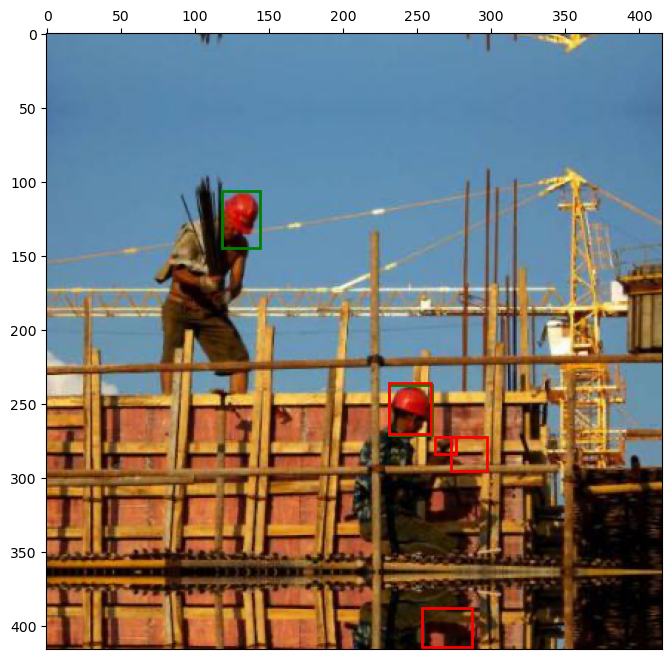

In [57]:
test_img = './images/hard_hat_workers4799.png'

image = plt.imread(test_img)
img = image.copy()

# bring color channels to front
img = np.transpose(img, (2, 0, 1)).astype(np.float32)

# convert to tensor; tensor([  3., 416., 416.], device='cuda:0')
img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled
    
# add batch dimension
img = torch.unsqueeze(img, 0)
with torch.no_grad(): #forward pass
    outputs = model(img.to(DEVICE))

# load all detection to CPU for further operations
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

# draw actual bounding boxes (to compare with predicted boxes)
act_box, act_lbl = get_box_lbl(test_img) #get actual boxes & labels
ax = plot_act(image, act_box)

# carry further only if there are detected boxes
if len(outputs[0]['boxes']) > 0:
    boxes = outputs[0]['boxes'].data.numpy() #converting tensor coordinates to numpy array
    scores = outputs[0]['scores'].data.numpy()
    lbls = outputs[0]['labels'].data.numpy()

    # filter out boxes according to `detection_threshold`
    boxes = boxes[scores > detection_threshold].astype(np.int32)
    lbls = lbls[scores > detection_threshold].astype(np.int32)
    pred_boxes = boxes.copy()

    # get all the predicited class names
    pred_class = [CLASS_NAME[i] for i in lbls]

    # draw predicted boxes (to compare with actuals)
    plot_pred(ax, pred_boxes, pred_class)
print("Green are the actual boxes, red & blue boxes are predicted by Faster RCNN model.")

In [58]:
act_box

[[231, 237, 260, 271], [118, 106, 144, 145]]

In [55]:
# test

Green are the actual boxes, red & blue boxes are predicted by Faster RCNN model.


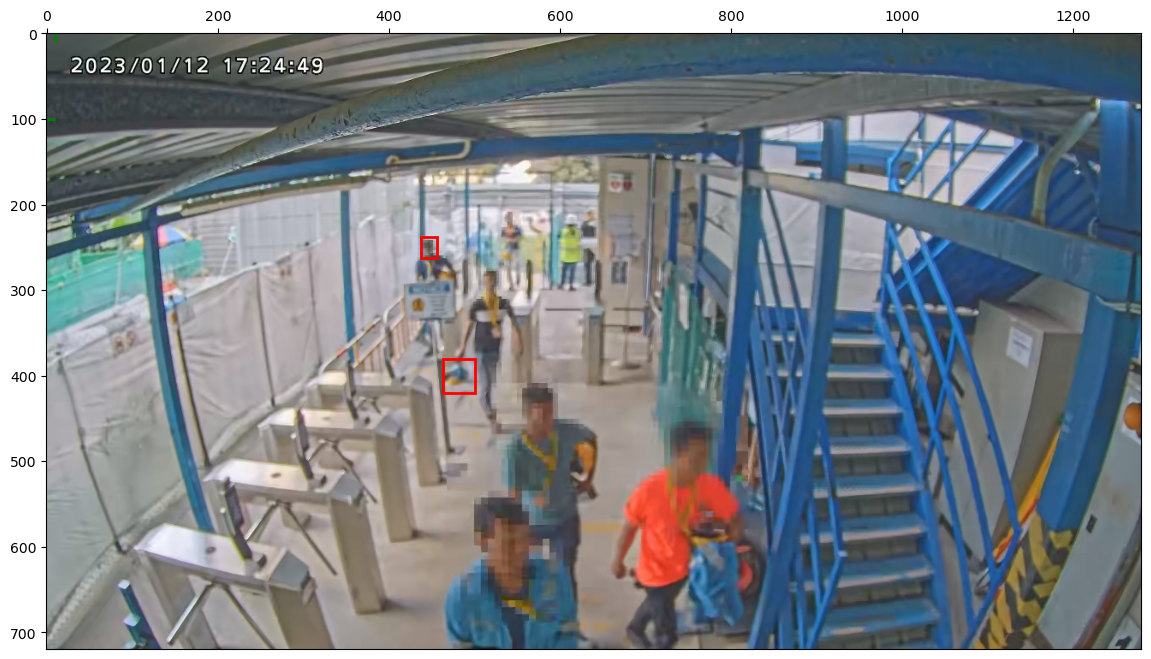

In [85]:
test_img = '../helmet_img/1159.png'

#test_img = '../helmet_img/1050.png'


image = plt.imread(test_img)
img = image.copy()

# bring color channels to front
img = np.transpose(img, (2, 0, 1)).astype(np.float32)

# convert to tensor; tensor([  3., 416., 416.], device='cuda:0')
img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled
    
# add batch dimension
img = torch.unsqueeze(img, 0)
with torch.no_grad(): #forward pass
    outputs = model(img.to(DEVICE))

# load all detection to CPU for further operations
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

# draw actual bounding boxes (to compare with predicted boxes)
# act_box, act_lbl = get_box_lbl(test_img) #get actual boxes & labels

act_box = [[0, 100, 10, 100], [10, 0, 10, 10]]

ax = plot_act(image, act_box)

# carry further only if there are detected boxes
if len(outputs[0]['boxes']) > 0:
    boxes = outputs[0]['boxes'].data.numpy() #converting tensor coordinates to numpy array
    scores = outputs[0]['scores'].data.numpy()
    lbls = outputs[0]['labels'].data.numpy()

    # filter out boxes according to `detection_threshold`
    boxes = boxes[scores > detection_threshold].astype(np.int32)
    lbls = lbls[scores > detection_threshold].astype(np.int32)
    pred_boxes = boxes.copy()

    # get all the predicited class names
    pred_class = [CLASS_NAME[i] for i in lbls]

    # draw predicted boxes (to compare with actuals)
    plot_pred(ax, pred_boxes, pred_class)
print("Green are the actual boxes, red & blue boxes are predicted by Faster RCNN model.")